<a href="https://colab.research.google.com/github/phaneo/TF2-Complete/blob/main/05_Transfer_Learning_With_TF_Part2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TF Part 2 - Fine tuning

## Creating helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-10 04:36:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: â€˜helper_functions.pyâ€™

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-10 04:36:19 (38.6 MB/s) - â€˜helper_functions.pyâ€™ saved [10246/10246]



In [ ]:
from helper_functions import *

## Let's get some data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

--2022-08-10 04:36:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.250.1.128, 108.177.121.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: â€˜10_food_classes_10_percent.zipâ€™

10_food_classes_10_ 100%[===================>] 160.74M   201MB/s    in 0.8s    

2022-08-10 04:36:24 (201 MB/s) - â€˜10_food_classes_10_percent.zipâ€™ saved [168546183/168546183]



In [ ]:
# Check out how many images & directories are there in our dataset
walk_through_dir("10_food_classes_10_percent/")

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tr

In [ ]:
# Create training and test directory paths

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                    image_size = IMG_SIZE,
                                                                    label_mode = 'categorical',
                                                                    batch_size = BATCH_SIZE)

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size = IMG_SIZE,
                                                        label_mode = 'categorical',
                                                        batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 21.505102    35.5051      44.5051    ]
   [ 18.836735    32.836735    41.836735  ]
   [ 22.265306    35.265305    44.265305  ]
   ...
   [ 41.800976    60.800976    93.80097   ]
   [ 29.974485    48.974483    81.97449   ]
   [ 35.586895    54.586895    87.5869    ]]

  [[ 23.122448    35.127552    44.459183  ]
   [ 32.005104    44.806126    53.87245   ]
   [ 25.290817    37.647957    46.862244  ]
   ...
   [ 34.71424     53.07145     86.28571   ]
   [ 32.928585    51.862247    85.061264  ]
   [ 37.193985    55.193985    91.193985  ]]

  [[ 21.852041    29.42347     42.637753  ]
   [ 31.061224    39.030613    52.045918  ]
   [ 27.62245     37.239796    49.545918  ]
   ...
   [ 32.88773     48.88773     84.459206  ]
   [ 34.41326     51.770405    89.98469   ]
   [ 29.800903    47.800903    86.22948   ]]

  ...

  [[ 12.147973     7.576501     1.790765  ]
   [ 15.357208    10.785736     5.        ]
   [ 13.           8.428528     4.214264  ]
   ...
   [  7.403117     3.831

## Model 0: Creating a feature extraction model using TF Functional API

In [ ]:
# 1. Create a base model using tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create inputs into the model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

# 4. If using ResNet50V2, need to normalize the inputs. EfficientNet has rescaling in-built
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs into the model: {x.shape}")

# 6. Average Pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

# 8. Combine the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = len(test_data),
                        callbacks = [create_tensorboard_callback(dir_name = "Tensorboard",
                                                                experiment_name = "EfficientNetV2")])

24289280/24274472 [==============================] - 1s 0us/step
Shape after passing inputs into the model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: Tensorboard/EfficientNetV2/20220810-043635
Epoch 1/5
24/24 [==============================] - 222s 8s/step - loss: 1.9188 - accuracy: 0.3933 - val_loss: 1.3487 - val_accuracy: 0.7072
Epoch 2/5
24/24 [==============================] - 180s 8s/step - loss: 1.1226 - accuracy: 0.7573 - val_loss: 0.8928 - val_accuracy: 0.8032
Epoch 3/5
24/24 [==============================] - 158s 7s/step - loss: 0.8089 - accuracy: 0.8240 - val_loss: 0.7144 - val_accuracy: 0.8336
Epoch 4/5
24/24 [==============================] - 159s 7s/step - loss: 0.6463 - accuracy: 0.8560 - val_loss: 0.6207 - val_accuracy: 0.8476
Epoch 5/5
24/24 [==============================] - 179s 8s/step - loss: 0.5507 - accuracy: 0.8760 - val_loss: 0.5640 - val_accuracy: 0.8540


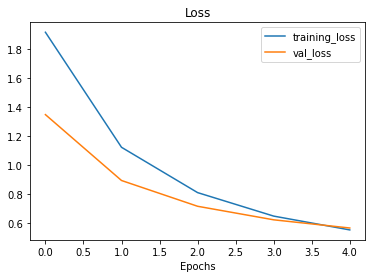

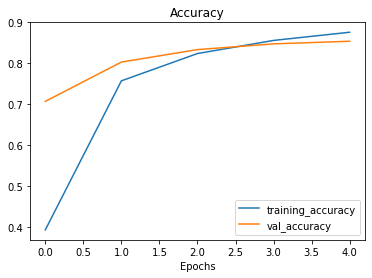

In [ ]:
plot_loss_curves(history_0)

In [ ]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_add
20 block3a_expand_conv
21 block3a_expand_bn
22 block3a_expand_activation
23 block3a_project_conv
24 block3a_project_bn
25 block3b_expand_conv
26 block3b_expand_bn
27 block3b_expand_activation
28 block3b_project_conv
29 block3b_project_bn
30 block3b_add
31 block4a_expand_conv
32 block4a_expand_bn
33 block4a_expand_activation
34 block4a_dwconv2
35 block4a_bn
36 block4a_activation
37 block4a_se_squeeze
38 block4a_se_reshape
39 block4a_se_reduce
40 block4a_se_expand
41 block4a_se_excite
42 block4a_project_conv
43 block4a_project_bn
44 block4b_expand_conv
45 block4b_expand_bn
46 block4b_expand_a

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


## Getting a feature vector from a trained model

Global Average Pooling 2D Layer - When our input tensor of size (None, 7, 7, 1280) goes through GlobalAveragePooling2D layer, it turns into (None, 1280).

In [ ]:
input_shape = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(shape = input_shape)

print(f"Random input tensor:\n{input_tensor}\n")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]



In [ ]:
output = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
output.shape, output

(TensorShape([1, 3]),
 <tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>)

In [ ]:
# Let's replicate the GlobalAveragePooling2D operation
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

In [ ]:
output_maxpool = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
output_maxpool, output_maxpool.shape

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>,
 TensorShape([1, 3]))

In [ ]:
tf.reduce_max(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of Transfer Learning experiments

Having seen the incredible results transfer learning can get with only 10% of training data, let's setup a few experiments to see how it works with 1% of the training data.

1. `model_1` - use feature extraction transfer learning with 1% of training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% of training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning with 10% of training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning with 100% of training data with data augmentation.

In [ ]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-08-10 04:51:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.251.120.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: â€˜10_food_classes_1_percent.zipâ€™

10_food_classes_1_p 100%[===================>] 127.42M  80.8MB/s    in 1.6s    

2022-08-10 04:51:41 (80.8 MB/s) - â€˜10_food_classes_1_percent.zipâ€™ saved [133612354/133612354]



In [ ]:
# Create training & test dirs

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir_1_percent = "10_food_classes_1_percent/test/"

In [ ]:
walk_through_dir("10_food_classes_1_percent/")

There are 2 directories and 0 images in '10_food_classes_1_percent/'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There 

## Getting and preprocessing data for model_1

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1_percent,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing`

Benefits of using data augmentation inside the model are:
* Use of GPU acceleration for augmentation,
* Portability, since the augmentation will be part of the exported model. So we can use it elsewhere.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms etc.
data_aug = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescaling(1/255.)
], name = "data_augmentation")

### Visualize our data augmentation layer

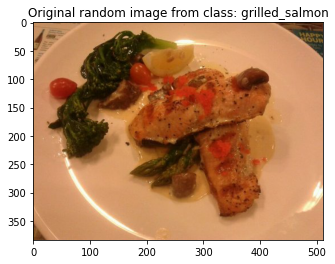

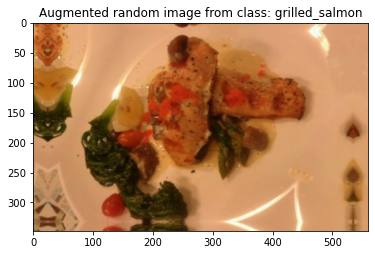

In [ ]:
# View a random image and compare it to its augmented version

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

random_img = random.choice(os.listdir(target_dir))
random_img_path = target_dir + '/' + random_img

img = mpimg.imread(random_img_path)
plt.title(f"Original random image from class: {target_class}")
plt.imshow(img)
plt.show()

# Plot the augmented image
aug_img = data_aug(img, training=True)
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.imshow(tf.squeeze(aug_img)/255.)
plt.show()

## Model_1: Feature extraction transfer learning on 1% data with data augmentation

In [ ]:
# Setup input shape and base model. Freeze the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=input_shape, name = "input_layer")

# Add data augmentation model as a layer
x = data_aug(inputs, training = True)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = "global_avgpooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                         experiment_name = "1_percent_data_aug")])

16719872/16705208 [==============================] - 0s 0us/step
Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220810-045148
Epoch 1/5
3/3 [==============================] - 97s 43s/step - loss: 2.4179 - accuracy: 0.1000 - val_loss: 2.2369 - val_accuracy: 0.1826
Epoch 2/5
3/3 [==============================] - 45s 21s/step - loss: 2.1925 - accuracy: 0.2143 - val_loss: 2.1257 - val_accuracy: 0.2286
Epoch 3/5
3/3 [==============================] - 46s 22s/step - loss: 1.9982 - accuracy: 0.3571 - val_loss: 2.0354 - val_accuracy: 0.2829
Epoch 4/5
3/3 [==============================] - 43s 21s/step - loss: 1.8528 - accuracy: 0.5286 - val_loss: 1.9375 - val_accuracy: 0.3438
Epoch 5/5
3/3 [==============================] - 46s 22s/step - loss: 1.6895 - accuracy: 0.5429 - val_loss: 1.8691 - val_accuracy: 0.3882


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avgpooling_layer (Gl  (None, 1280)             0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
results_1_per_data_aug = model_1.evaluate(test_data)
results_1_per_data_aug

79/79 [==============================] - 163s 2s/step - loss: 1.8808 - accuracy: 0.3856


[1.880801796913147, 0.3856000006198883]

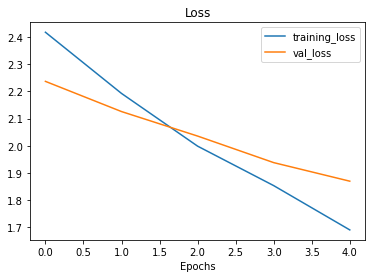

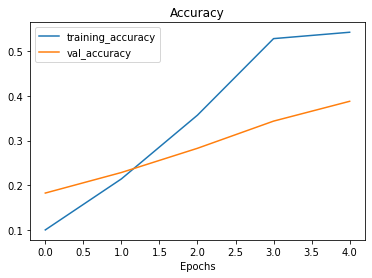

In [ ]:
plot_loss_curves(history_1_percent)

## Model_2: feature extraction transfer learning with 10% data and data augmentation

In [ ]:
train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size = IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1/255.)
], name = "data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model_1 = tf.keras.applications.EfficientNetB0(include_top= False)
base_model_1.trainable = False

# Create inputs and outputs
inputs = tf.keras.layers.Input(shape = input_shape, name = "input_shape")
x = data_augmentation(inputs)
x = base_model_1(x, training = False)
x = layers.GlobalAveragePooling2D(name = "global_avgpooling_2d")(x)

outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])


In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avgpooling_2d (Globa  (None, 1280)             0         
 lAveragePooling2D)                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

In [ ]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = "epoch",
                                                         verbose = 1)

In [ ]:
history_10_percent = model_2.fit(train_data_10_percent,
                                 epochs = 5,
                                 steps_per_epoch = len(train_data_10_percent),
                                 validation_data = test_data,
                                 validation_steps = int(0.25 * len(test_data)),
                                 callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                          experiment_name = "10_percent_data_aug"), 
                                              checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220810-050233
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0173 - accuracy: 0.3427
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 92s 4s/step - loss: 2.0173 - accuracy: 0.3427 - val_loss: 1.5182 - val_accuracy: 0.6398
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3662 - accuracy: 0.6667
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 90s 4s/step - loss: 1.3662 - accuracy: 0.6667 - val_loss: 1.0864 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0693 - accuracy: 0.7467
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 92s 4s/step - loss: 1.0693 - accuracy: 0.7467 - val_loss: 0.8543 - val_accuracy: 0.7928
Epoch 4/5


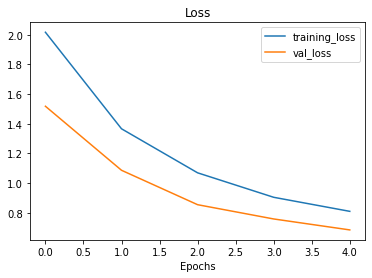

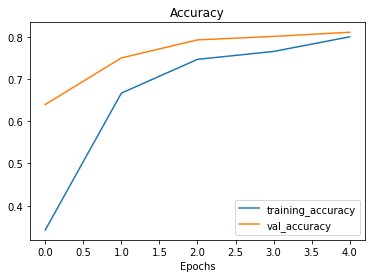

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 138s 2s/step - loss: 0.5640 - accuracy: 0.8540


[0.5639975666999817, 0.8539999723434448]

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

10/79 [==>...........................] - ETA: 2:12 - loss: 0.6997 - accuracy: 0.8000

KeyboardInterrupt: ignored

### Loading in checkpointed weights

Returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model

model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)
loaded_weights_model_results

In [ ]:
results_10_percent_data_aug == loaded_weights_model_results

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np

np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

In [ ]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

## Model_3: Fine-tuning an existing model on 10% data

> ðŸ”‘ Fine-tuning works best after training a feature extraction model for a few epochs with larges amounts of custom data

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer.name, '-', layer.trainable)

In [ ]:
# No. of layers in EfficientNetB0, whether they are trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, '-', layer.trainable)

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base model to trainable

base_model_1.trainable = True

# Freeze all layers except for the last 10
for layer in base_model_1.layers[:-10]:
  layer.trainable = False

# Recompile (everytime we make changes to the model we need to recompile)
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), # when fine-tuning typically lower the lr by 10x
                metrics = ["accuracy"])

> ðŸ”‘ **Note** - When fine-tuning its best practise to lower the learning rate by some amount. A good rule of thumb is at least 10x lower.

In [ ]:
# Check which layers are tuneable
for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

In [ ]:
print(len(model_2.trainable_variables))

In [ ]:
initial_epochs = 5

In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent.epoch[-1],
                                               callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                        experiment_name = "10_percent_fine_tune_last_10")])

In [ ]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

In [ ]:
plot_loss_curves(history_fine_10_percent_data_aug)

In [ ]:
# Let's create a function that can compare training histories

def compare_history(original_history, new_history, initial_epochs = 5):
  """
  Compares two Tensorflow History objects
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = "training accuracy")
  plt.plot(total_val_acc, label = "training val accuracy")

  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = 'Start fine tuning')
  plt.legend(loc = "lower right")
  plt.title("Training and validation accuracy")



  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = "training loss")
  plt.plot(total_val_loss, label = "training val loss")

  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label = 'Start fine tuning')
  plt.legend(loc = "lower right")
  plt.title("Training and validation loss")

In [ ]:
compare_history(history_10_percent,
                history_fine_10_percent_data_aug,
                initial_epochs = 5)

## Model_4: Fine tuning an existing model on 100% of the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

In [ ]:
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
walk_through_dir("10_food_classes_all_data/")

In [ ]:
# Setup data inputs
IMG_SIZE = (224, 224)
train_data_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                 image_size = IMG_SIZE,
                                                                 label_mode = "categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical")

The test dataset loaded here is the same as the test data we've been using with all the experiments. Let's verify this.

In [ ]:
model_2.evaluate(test_data)

In [ ]:
results_fine_tune_10_percent

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

In [ ]:
# Check which layers are tuneable

for layer_num, layer in enumerate(model_2.layers):
  print(layer_num, layer.name, layer.trainable)

In [ ]:
for layer_num, layer in enumerate(model_2.layers[2].layers):
  print(layer_num, layer.name, layer.trainable)

In [ ]:
model_2.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                metrics = ["accuracy"])

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_fine_tune_full_data = model_2.fit(train_data_full,
                                          epochs = fine_tune_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25*len(test_data)),
                                          initial_epoch = history_10_percent.epoch[-1],
                                          callbacks = [create_tensorboard_callback(dir_name = "transfer_learning",
                                                                                   experiment_name = "10_classes_fine_tune_full_data")])

In [ ]:
compare_history(original_history = history_10_percent,
                new_history = history_fine_tune_full_data,
                initial_epochs = 5)